# Grapevine Leaf Identify with MobileNetV3Large

## Introduction
In this notebook, we will address the problem of grapevine species recognition from leaves using techniques of artificial vision. This problem is of great importance in viticulture, as precise identification of grapevine species can influence various areas such as crop management, disease detection, and production optimization.

To solve this challenge, we will employ the transfer learning approach using the pre-trained MobileNetV3Large architecture. Transfer learning allows us to leverage the knowledge learned by the neural network on a related task and apply it to our specific problem. MobileNetV3Large is a computationally efficient convolutional neural network (CNN), making it suitable for applications on devices with limited resources.

Throughout this notebook, we will step-by-step explore the process of building and training our grapevine species recognition model, as well as evaluating the model's performance.

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

from PIL import Image, ImageOps
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, Input, Rescaling,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness)
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

# Ignore warnings
warnings.filterwarnings("ignore")

2024-05-02 18:50:22.995242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 18:50:22.995352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 18:50:23.121099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis (EDA)
In this section, we will perform an exploratory data analysis to better understand the nature of our dataset containing images of grapevine leaves. This analysis will allow us to gain valuable insights into the classes of leaves present, the dimensions of the images, and the distribution of classes.

Through this comprehensive analysis, we will gain a complete understanding of our dataset, enabling us to make informed decisions during the process of building and training the grapevine leaf species recognition model.

### Leaf Classes
We begin by examining the classes of leaves to which our images belong. It is crucial to have a clear understanding of the classes represented in our dataset before proceeding with the construction of the recognition model.

In [2]:
# Directory where the images are located
base_dir = '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset'

# Seed for reproducibility
seed = 1234

# Get list of directories representing different classes
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Print the classes present in the dataset
print('Classes in the dataset:', classes)

Classes in the dataset: ['Buzgulu', 'Ala_Idris', 'Nazli', 'Dimnit', 'Ak']


### Image Visualization
Next, we will display a set of randomly selected images to visualize the variety of leaves present in our dataset. This visual exploration will help us identify potential challenges in the classification process, such as variations in lighting, deformations, occlusions, among others.

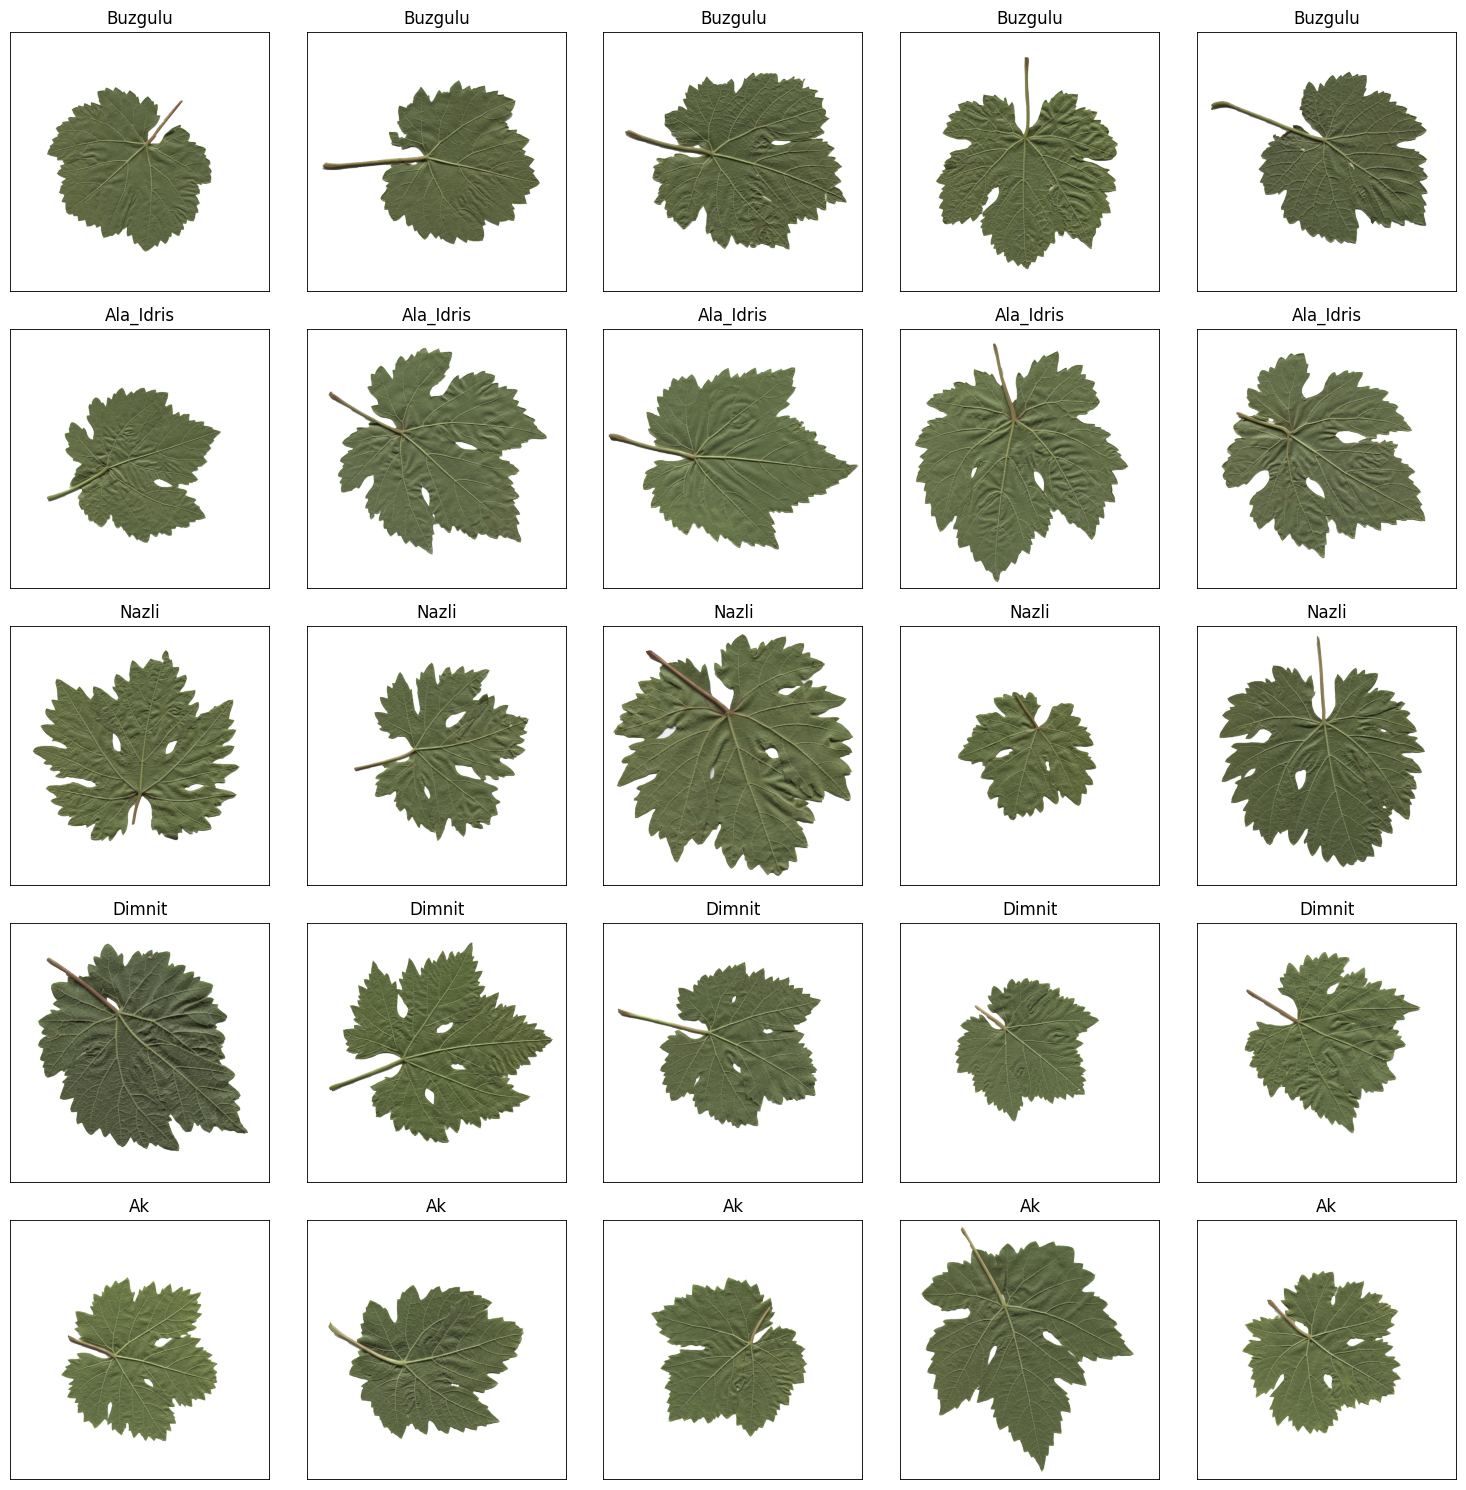

In [3]:
num_images_to_display = 5

# Create a new figure with a suitable size
plt.figure(figsize = (15, 3 * len(classes)))

# Loop over each class
for i, class_name in enumerate(classes, 1):
    class_dir = os.path.join(base_dir, class_name)
    class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)[:num_images_to_display]]
    
    # Iterate over the images in the current class
    for j, image_path in enumerate(class_images, 1):
        # Create a subplot for each image
        plt.subplot(len(classes), num_images_to_display, (i-1) * num_images_to_display + j)
        
        # Open the image using PIL
        with Image.open(image_path) as img:
            # Add a black border to the image to enhance visibility
            img_with_border = ImageOps.expand(img, border = 2, fill = 'black')
            plt.imshow(img_with_border)
        
        # Turn off axis labels
        plt.axis('off')
        
        # Set title for the subplot with class name
        plt.title(class_name)

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Display the plot
plt.show()

### Image Dimensions
It is important to check the dimensions of the images in our dataset to ensure that they all have the same size and format. In case of discrepancies in dimensions, we will consider resizing all images to a uniform size to ensure consistency and facilitate processing by the recognition model.

In [4]:
# Get the unique dimensions of the images
unique_dimensions = set()

# Iterate over each class
for class_name in classes:
    # Get the list of image filenames in the class directory
    images_in_class = os.listdir(os.path.join(base_dir, class_name))
    
    # Iterate over each image in the class
    for image_name in images_in_class:
        # Construct the full path to the image
        image_path = os.path.join(base_dir, class_name, image_name)
        
        # Read the image using matplotlib
        image = plt.imread(image_path)
        
        # Add the dimensions of the image to the set of unique dimensions
        unique_dimensions.add(image.shape)

# Print the unique dimensions of the images
print("Unique dimensions of the images:")
for dimensions in unique_dimensions:
    print(f"{dimensions[0]} x {dimensions[1]}")

Unique dimensions of the images:
511 x 511


### Class Distribution
Finally, we will examine the distribution of classes in our dataset to determine if there is an adequate balance between the different species represented. An imbalanced distribution can bias the model's performance towards over-represented classes, negatively affecting its ability to generalize in real-world situations.

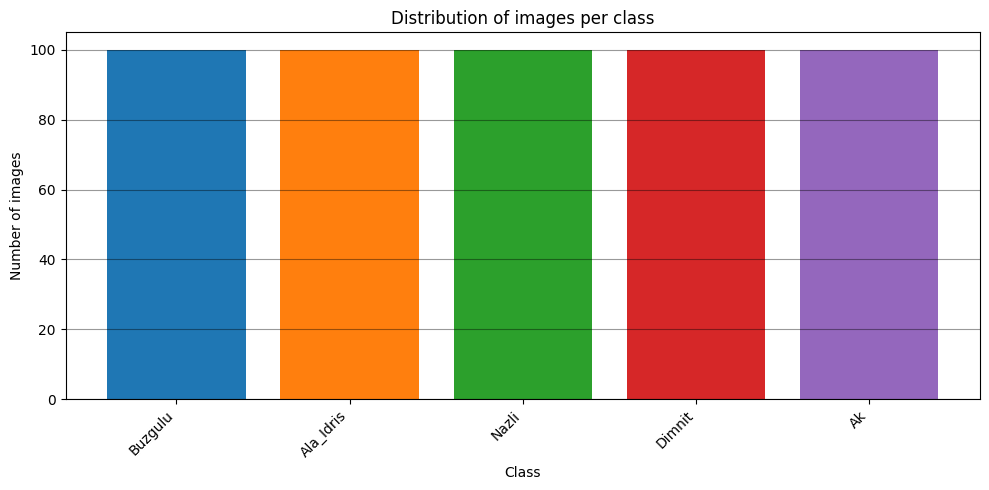

In [5]:
# Count the number of images per class
count_per_class = []
for class_name in classes:
    # Get the list of image filenames in the class directory
    images_in_class = os.listdir(os.path.join(base_dir, class_name))
    
    # Append the number of images in the class to the list
    count_per_class.append(len(images_in_class))

# Create a colormap with a unique color for each class
cmap = cm.tab10

# Create the histogram with distinct colors for each class
plt.figure(figsize = (10, 5))
bars = plt.bar(classes, count_per_class, color = cmap(range(len(classes))))
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of images per class')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()

# Add horizontal grid lines
plt.grid(axis = 'y', which = 'both', alpha = 0.4, color = 'black')

# Show the plot
plt.show()

## Data Preprocessing
In this section, we will address the preprocessing of the data before training our classification model. This process will include splitting the data into training and validation sets, as well as applying data augmentation techniques to increase the diversity of the training set.

### Data Splitting
We will start by dividing our dataset into training and validation sets. We will follow an 80% data split for training and 20% for validation. Subsequently, we will verify the number of images for each class in each set to ensure that the split is representative and balanced.

In [6]:
# Define the desired image size
image_size = (511, 511)

# Define the batch size for the dataset
batch_size = 32

# Create training and validation datasets
train_ds, validation_ds = image_dataset_from_directory(
    base_dir,  # Directory containing the images
    validation_split = 0.2,  # Splitting 20% of the data for validation
    subset = 'both',  # Use both training and validation subsets
    label_mode = 'categorical',  # Use categorical labels
    seed = seed,  # Seed for reproducibility
    image_size = image_size,  # Resizing images to desired dimensions
    batch_size = batch_size,  # Define batch size
    shuffle = True  # Shuffle the dataset
)

Found 500 files belonging to 5 classes.
Using 400 files for training.
Using 100 files for validation.


In [7]:
# Create dictionaries to count the number of images per class for training and validation sets
train_counter = {name: 0 for name in classes}
validation_counter = {name: 0 for name in classes}

# Count the images in the training dataset
for images, labels in train_ds:
    for label in labels:
        # Retrieve the class name using argmax of the labels array
        label = classes[np.argmax(label)]
        train_counter[label] += 1

# Count the images in the validation dataset
for images, labels in validation_ds:
    for label in labels:
        # Retrieve the class name using argmax of the labels array
        label = classes[np.argmax(label)]
        validation_counter[label] += 1

# Print the results
print(f"Train: {train_counter}")
print(f"Validation: {validation_counter}")

Train: {'Buzgulu': 79, 'Ala_Idris': 81, 'Nazli': 79, 'Dimnit': 80, 'Ak': 81}
Validation: {'Buzgulu': 21, 'Ala_Idris': 19, 'Nazli': 21, 'Dimnit': 20, 'Ak': 19}


### Data Augmentation
Since we have a limited dataset, we will apply data augmentation techniques to increase the variability of our training set. These techniques will include operations such as random flipping, rotation, zooming, contrast adjustment, among others. Data augmentation will allow us to generate more training samples from the existing images, which will help improve the model's generalization ability.

In [8]:
# Define the augmentation layers
augmentation_layers = [
    RandomFlip("horizontal_and_vertical", seed = seed),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2, seed = seed),  # Randomly rotate images by a maximum of 20 degrees
    RandomZoom(0.2, seed = seed),  # Randomly zoom into images by a maximum of 20%
    RandomContrast(0.2, seed = seed),  # Randomly adjust contrast by a maximum of 20%
    RandomBrightness(0.2, seed = seed)  # Randomly adjust brightness by a maximum of 20%
]

# Define a function to apply data augmentation
def data_augmentation(images):
    for layer in augmentation_layers:
        x = layer(images)  # Apply each augmentation layer sequentially
        return images  # Return the augmented images

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

### Parallelization and Prefetching
Once data augmentation is applied, we will parallelize the process to improve the performance of our system. Parallelization will allow us to make the most of the available computational resources, speeding up the processing time. Additionally, we will implement prefetching of samples into the GPU memory to maximize GPU utilization. This technique will enable us to efficiently load data samples onto the GPU, reducing wait times during model training.

In [9]:
# Apply `data_augmentation` to the training images using map function
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),  # Apply data_augmentation function to each image
    num_parallel_calls = tf_data.AUTOTUNE,  # Parallelize the mapping operation for better performance
)

# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)  # Prefetch the next batch of data in parallel while the GPU is busy
validation_ds = validation_ds.prefetch(tf_data.AUTOTUNE)  # Prefetch validation data in the same way as training data

## Model Creation
In this section, we will proceed with the creation and configuration of the vine species recognition model using the pre-trained MobileNetV3Large architecture.

### Input Layer and Rescaling
We will start by adding an input layer to receive the vine leaf images as input to the model. Additionally, we will apply rescaling to center the inputs around 0, which will help improve the model's convergence during training.

### MobileNetV3Large
We will use the MobileNetV3Large architecture as the base of our model. This architecture is known for its efficiency and performance in computer vision tasks. However, we will freeze the pre-trained layers to prevent them from being updated during training, thus maintaining the weights learned during pre-training.

### Dense Layers and Dropout
Next, we will add a dense layer with 1024 units followed by a dropout layer. The dropout layer will help regularize the model and prevent overfitting by temporarily removing connections between neurons during training. We will then add another dense layer with 512 units and another dropout layer to continue the regularization process.

### Output Layer
Finally, we will add a dense layer with a softmax activation function to perform the classification of vine species. The softmax activation will provide us with the probability that an image belongs to each of the vine leaf classes.

### Training Configuration
Before starting training, we will configure relevant parameters such as learning rate, loss function, and optimizer. We will use an Adam optimizer and a categorical_crossentropy loss function suitable for multi-class classification.

In [10]:
# Set seed for reproducibility
tf.random.set_seed(seed)

# Define the input layer with the desired image size
inputs = Input(shape = (511, 511, 3))

# Add a rescaling layer to center the inputs around 0
rescaling_layer = Rescaling(scale = 1.0 / 127.5, offset =- 1.0)

# Apply rescaling to input
x = rescaling_layer(inputs)

# Load the MobileNetV3Large model excluding the preprocessing layer
base_model = MobileNetV3Large(include_top = False, weights = 'imagenet', include_preprocessing = False)

# Freeze the pre-trained layers
base_model.trainable = False

# Pass the input through the base model
x = base_model(x)

# Global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dense layer with ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dense layer with ReLU activation
x = Dense(512, activation='relu')(x)

# Dropout layer to reduce overfitting
x = Dropout(0.2)(x)

# Add the final output layer with softmax activation for classification
output = Dense(len(classes), activation = 'softmax')(x)

# Create the complete model
model = Model(inputs = inputs, outputs = output)

# Compile the model (configure optimizer, loss function, and desired metrics)
model.compile(optimizer = Adam(learning_rate = 1e-3),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Show a summary of the model
model.summary(show_trainable = True)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 511, 511, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 511, 511, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ MobilenetV3large            │ (None, 16, 16, 960)   │  2,996,352 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 960)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │    984,064 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 5)             │      2,565 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 4,507,781 (17.20 MB)

 Trainable params: 1,511,429 (5.77 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Model Training
In this section, we will proceed to train our recognition model using the prepared dataset. During training, we will implement the early stopping technique to prevent overfitting and ensure optimal convergence of the model.

### Early Stopping
To prevent overfitting of the model during training, we will implement the early stopping technique. This technique monitors a specific metric, such as loss on the validation set, and stops training if no improvement is observed for a certain number of consecutive epochs. Early stopping allows us to halt training before the model starts overfitting to the training data, thereby improving its generalization ability.

### Model Training
Once everything is set up, we will proceed with training the model using the prepared training and validation datasets. We will monitor the training progress and the objective metric using the early stopping technique to properly halt training when necessary.

With these techniques implemented, we will be ready to train our model effectively and obtain reliable results in classifying grapevine species from leaf images.

In [11]:
# Define patience for Early Stopping
patience = 5

# Define number of epochs
epochs = 50

# Define Early Stopping callback
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)
]

# Train the model with Early Stopping
history = model.fit(
    train_ds,  # Training dataset
    epochs = epochs,  # Number of epochs
    validation_data = validation_ds,  # Validation dataset
    callbacks = callbacks  # Early Stopping callback
)

Epoch 1/50
 2/13 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.1719 - loss: 2.1284

I0000 00:00:1714675874.884689     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.2538 - loss: 2.3024 - val_accuracy: 0.5000 - val_loss: 1.1846
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5166 - loss: 1.1905 - val_accuracy: 0.7600 - val_loss: 0.7039
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6980 - loss: 0.8143 - val_accuracy: 0.8000 - val_loss: 0.5467
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7936 - loss: 0.5299 - val_accuracy: 0.9000 - val_loss: 0.3540
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.8739 - loss: 0.3823 - val_accuracy: 0.9500 - val_loss: 0.2675
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9261 - loss: 0.2479 - val_accuracy: 0.9300 - val_loss: 0.2236
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9462 - loss: 0.1610 - val_accuracy: 0.9100 - val_loss: 0.2326
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9656 - loss: 0.1336 - val_accuracy: 0.9200 - val_lo

## Model Evaluation
Here, we will evaluate the performance of our model after training. We will perform a comparative analysis of the model's performance on the training and validation datasets throughout training, using metrics such as accuracy and loss. Additionally, we will generate plots to visualize how these metrics evolve over epochs and determine the best training epoch.

With this comprehensive evaluation, we will be able to determine the effectiveness and performance of the trained model and make informed decisions about its potential deployment in real-world applications.

### Comparative Analysis
We will start by comparing the model's performance on the training and validation datasets throughout training. We will use metrics such as accuracy and loss to evaluate how well the model generalizes to unseen data during training. We will identify the best training epoch based on these metrics.

To visualize the model's performance throughout training, we will generate plots showing accuracy and loss on the training and validation datasets over epochs. These plots will allow us to identify trends and assess the model's convergence during training.

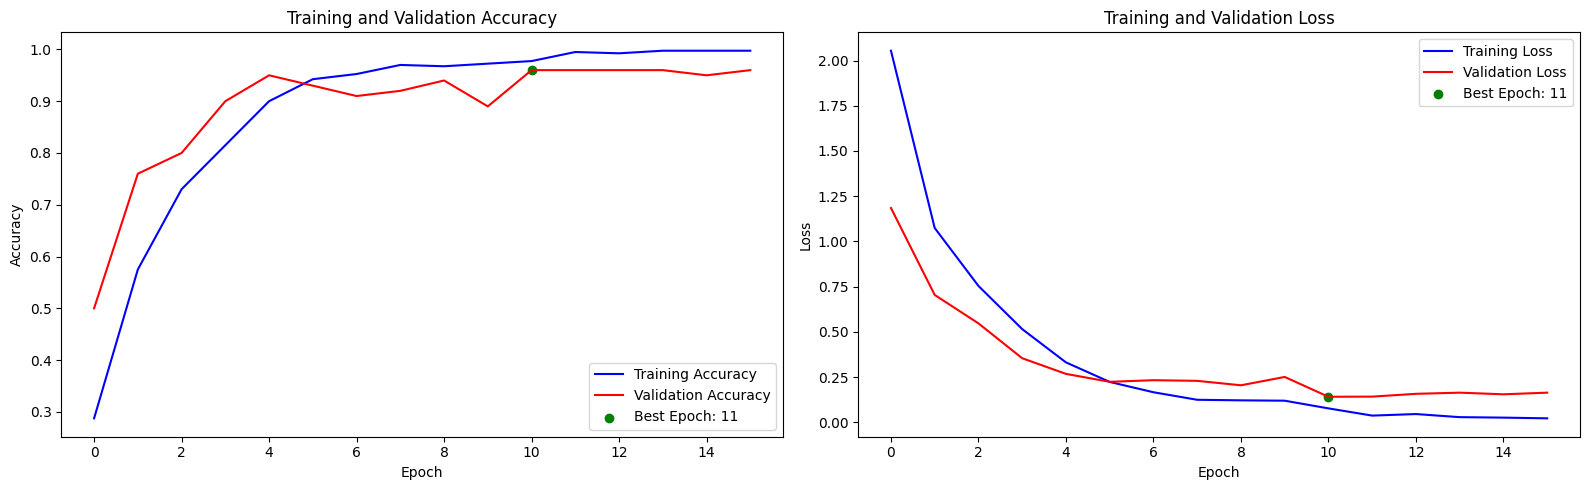

In [12]:
def plot_metrics(history):
    """
    Plot training and validation metrics.

    Args:
    - history: A history object returned by model.fit().
    """
    
    # Get the epoch with the highest validation accuracy
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
    
    # Create a subplot with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Plot training and validation accuracy
    axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend()

    # Plot training and validation loss
    axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Call plot_metrics with the history object returned by model.fit()
plot_metrics(history)

### Evaluation on Validation Data
Once the best training epoch is identified, we will evaluate the model on the validation data to obtain a final estimate of its performance. We will use the model's predictions to calculate the confusion matrix, which will provide metrics such as accuracy, recall, and F1 score for each vine leaf class.

In [13]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(validation_ds)
print("Loss on test data:", loss)
print("Accuracy on test data:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9538 - loss: 0.1474 
Loss on test data: 0.14095072448253632
Accuracy on test data: 0.9599999785423279


In [14]:
# Get model predictions on the test data
y_pred = model.predict(validation_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.argmax(np.concatenate([y for x, y in validation_ds]), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


              precision    recall  f1-score   support

     Buzgulu       1.00      0.95      0.98        21
   Ala_Idris       0.95      0.95      0.95        19
       Nazli       0.95      0.95      0.95        21
      Dimnit       0.95      0.95      0.95        20
          Ak       0.95      1.00      0.97        19

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



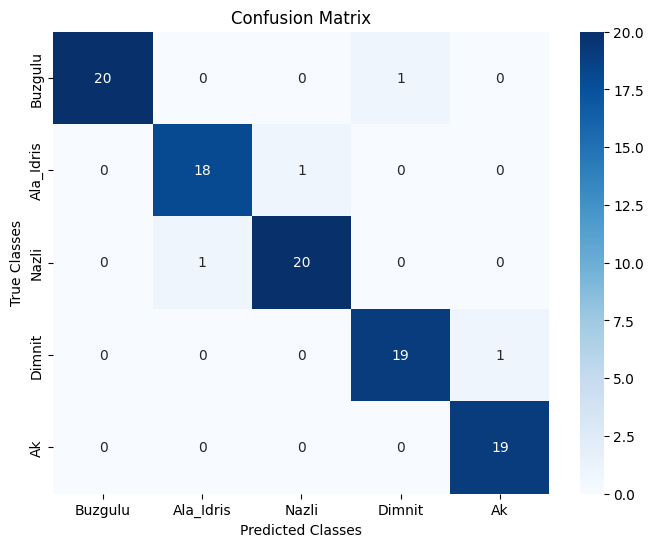

In [15]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Generate classification report with class names
report = classification_report(y_true, y_pred_classes, target_names=classes)

# Print classification report with class names
print(report)

# Create a heatmap of the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

### Interpretation of Results

Based on the obtained results, we can affirm that the model generalizes well, achieving an F1-Score of 0.96 on the test dataset. This indicates that the model strikes a solid balance between precision and recall in classifying the different classes.

- The model's precision ranges between 0.95 and 1.00 for different classes, indicating that most positive predictions are correct.
- Recall, which shows the model's ability to correctly identify positive instances, varies between 0.95 and 1.00.
- The macro average of precision, recall, and F1-Score is 96%, indicating consistent performance across all classes.
- The weighted average is also 96%, suggesting that the model is not biased towards any particular class and handles all classes equally well.

In summary, these results suggest that the model is robust and capable of effectively classifying instances into the provided classes.